In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

# This takes 4min 30s to run in Python 2.7
# But only 1min 30s to run in Python 3.5!

# Note: gym changed from version 0.7.3 to 0.8.0
# MontainCar episode lenght is capped at 200 in later versions.
# This means your agent can't learn as much in the earlier episodes
# since ther are no longer as long.
import gym
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

# SDGRegressor defaults:
# loss='squared_loss', penalty='l2', alpha=0.0001,
# l1_ratio=0.15, fit_intercept=True, n_iter=5, shuffle=True
# verbose=0, epsilon=0.1, random_state=None, learning_rate='invscaling'
# eta0=0.01, power_t=0.25, warm_start=False, average=False

In [1]:
class FeatureTransformer:
    def __init__(self, env, n_components=500):
        # generation of examples to train the FeatureTransformer
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        scaler = StandardScaler()
        scaler.fit(observation_examples)
        
        # Used to converte a state to a featurizes representation.
        # We use RBF kernels with different variances to cover different parts of the space
        featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma= 5.0, n_components= n_components)),
            ("rbf2", RBFSampler(gamma= 2.0, n_components= n_components)),
            ("rbf3", RBFSampler(gamma= 1.0, n_components= n_components)),
            ("rbf4", RBFSampler(gamma= 0.5, n_components= n_components))
        ])
        example_features = featurizer.fit_transform(scaler.transform(observation_examples))
        
        self.dimensions = example_features.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer
        
    def transform(self, observations):
        #print("observations:", observations)
        scaled = self.scaler.transform(observations)
        assert(len(scaled.shape) == 2)
        return self.featurizer.transform(scaled)

In [3]:
# Holds one SGDRegressor for each action
class Model:
    def __init__(self, env, feature_transformer, learning_rate):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        # create a model by action
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate= learning_rate)
            # initialization of model (for RBF)
            model.partial_fit(feature_transformer.transform( [env.reset()] ), [0])
            self.models.append(model)
            
    def predict(self, s):
        X = self.feature_transformer.transform([s])
        assert(len(X.shape) == 2)
        return np.array([m.predict(X)[0] for m in self.models])
    
    def update(self, s, a, G):
        X = self.feature_transformer.transform([s])
        assert(len(X.shape) == 2)
        # update the model of the action a
        self.models[a].partial_fit(X, [G])
        
    def sample_action(self, s, eps):
        # eps = 0
        # Technically, we don't need to do epsilon-greedy
        # because SGDRegressor predicts 0 for all states
        # until they are updated. This works as the 
        # "Optimistic Initial Values" method, since all
        # the reward for Montain Car are -1
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))

In [4]:
# return a list of states_and_rewards, and the total reward
def play_one(model, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    
    while not done and iters < 10000:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        # update the model
        G = reward + gamma*np.max(model.predict(observation)[0])
        model.update(prev_observation, action, G)
        
        totalreward += reward
        iters += 1
        
    return totalreward

In [5]:
def plot_cost_to_go(env, estimator, num_tiles = 20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num= num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num= num_tiles)
    X, Y = np.meshgrid(x, y)
    # both X and Y will be of shape (num_tiles, num_tiles)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))
    # Z will also be of shape (num_tiles, num_tiles)
    
    fig = plt.figure(figsize= (10, 5))
    ax = fig.add_subplot(111, projection= '3d')
    surf = ax.plot_surface(X, Y, Z,
                          rstride = 1, cstride = 1, cmap = matplotlib.cm.coolwarm,
                          vmin= -1.0, vmax= 1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Cost-To-Go == -V(s)')
    ax.set_title("Cost-To-Go Function")
    fig.colorbar(surf)
    plt.show()
    

In [6]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100): (t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


episode: 0 total reward: -200.0
episode: 100 total reward: -154.0
episode: 200 total reward: -86.0
avg reward for last 100 episodes: -129.19
total steps: 44362.0


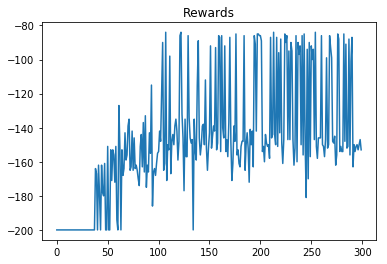

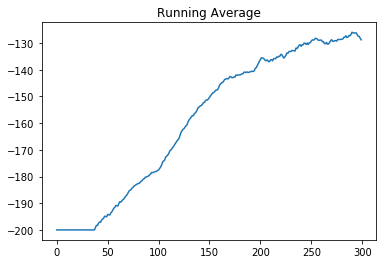

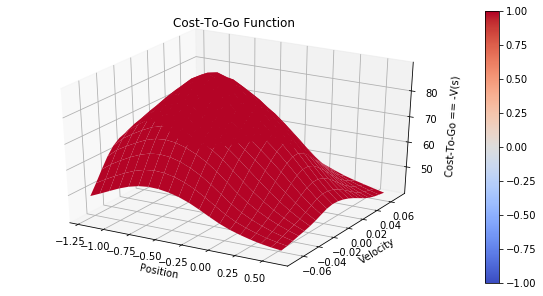

In [7]:
if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    ft = FeatureTransformer(env)
    model = Model(env, ft, "constant")
    # learning_rate = 10e-5
    # eps = 1.0
    gamma = 0.99
    
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
        
    N = 300
    totalrewards = np.empty(N)
    for n in range(N):
        # eps = 1.0/(0.1*n+1)
        eps = 0.1*(0.97**n)
        # eps = 0.5/np.sqrt(n+1)
        totalreward = play_one(model, eps, gamma)
        totalrewards[n] = totalreward
        if n % 100 == 0:
            print("episode:", n, "total reward:", totalreward)
    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", -totalrewards.sum())
    
    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()
    
    plot_running_avg(totalrewards)
    
    # plot the optimal state-value function
    plot_cost_to_go(env, model)